In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import pandas

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import cv2
import sys
import argparse

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, Function
from torchvision import datasets, models, transforms, utils
import torchvision
import torch.nn.functional as F
import torch.nn as nn

In [3]:
image_data_transforms = {
    'training': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [4]:
!mkdir Data

In [5]:
cp -r "/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification/Flower Classification/" /kaggle/working/Data/

In [8]:
train_dir = '/kaggle/working/Data/Flower Classification/Training Data'
valid_dir = '/kaggle/working/Data/Flower Classification/Validation Data'
test_dir = '/kaggle/working/Data/Flower Classification/Testing Data'

batch_size = 32
training_data = torchvision.datasets.ImageFolder(train_dir, transform=image_data_transforms['training'])
validation_data = torchvision.datasets.ImageFolder(valid_dir, transform=image_data_transforms['validation'])
testing_data = torchvision.datasets.ImageFolder(test_dir, transform=image_data_transforms['testing'])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)

In [9]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

class_names = {0: 'Daisy',
 1:'Lavender',
 2:'Lily',
 3:'Rose',
 4:'Sunflower'}
# Modify the classifier to match the number of flower classes
num_classes = len(class_names)
model.fc = nn.Linear(512, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s] 


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

Device: cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def plot_data_loader(data_loader, gridDims):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

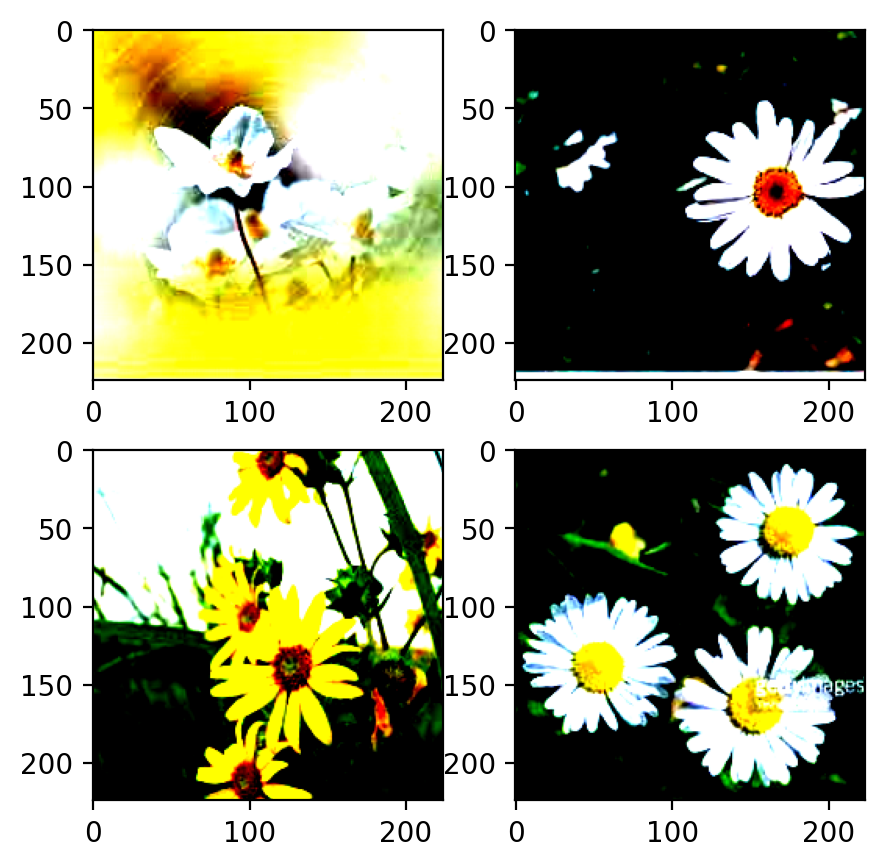

In [12]:
plot_data_loader(test_loader,[2,2])

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a test_loader that provides images
# test_loader is an iterator that returns images as inputs

# Get the batch of images from the test_loader
images, labels = next(iter(test_loader))

# Convert the images from tensor to numpy array
images = images.numpy()

# Get the number of images in the batch
num_images = images.shape[0]

# Create a subplot with appropriate number of rows and columns based on the number of images
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))




# # Set the figure size to (10,10)
# plt.figure(figsize=(20, 20))

# # Loop through each image and plot it in a subplot
# for i in range(num_images):
#     plt.subplot(num_rows, num_cols, i + 1)
#     plt.imshow(images[i].transpose((1, 2, 0)))  # Transpose to convert from (C, H, W) to (H, W, C)
#     plt.title(f'Class: {class_names[labels[i].item()]}')  # Use the dictionary to map class numbers to class names
#     plt.axis('off')

# # Show the plot
# plt.show()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
num_epochs = 30
dataframe = pandas.DataFrame({
    "Epoch":pandas.Series(dtype="int"),
    "train_loss":pandas.Series(dtype="float"),
    "train_accuracy":pandas.Series(dtype="float"),
    "val_loss":pandas.Series(dtype="float"),
    "val_accuracy":pandas.Series(dtype="float")
})
for epoch in range(num_epochs):
    # Train mode
    model.train()
    train_loss = 0
    train_correct = 0
    for feature, target in train_loader:
        feature, target = feature.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * feature.shape[0]
        train_correct += (output.argmax(1) == target).sum().item()
    train_loss /= len(training_data)
    train_accuracy = train_correct / len(training_data)

    # Validation mode
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for feature, target in validation_loader:
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)
            val_loss += loss.item() * feature.shape[0]
            val_correct += (output.argmax(1) == target).sum().item()
    val_loss /= len(validation_data)
    val_accuracy = val_correct / len(validation_data)

    # Print results for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy*100, val_loss, val_accuracy*100))
    dataframe.loc[len(dataframe.index)] = [epoch+1, train_loss, train_accuracy, val_loss, val_accuracy]

Epoch [1/30], Train Loss: 0.5127, Train Acc: 83.40%, Val Loss: 0.3646, Val Acc: 88.48%
Epoch [2/30], Train Loss: 0.3052, Train Acc: 90.26%, Val Loss: 0.3291, Val Acc: 89.68%
Epoch [3/30], Train Loss: 0.2498, Train Acc: 91.88%, Val Loss: 0.4687, Val Acc: 85.96%
Epoch [4/30], Train Loss: 0.1985, Train Acc: 94.22%, Val Loss: 0.4084, Val Acc: 87.36%
Epoch [5/30], Train Loss: 0.1541, Train Acc: 94.98%, Val Loss: 0.3310, Val Acc: 89.92%
Epoch [6/30], Train Loss: 0.1275, Train Acc: 96.14%, Val Loss: 0.3900, Val Acc: 90.48%
Epoch [7/30], Train Loss: 0.1491, Train Acc: 95.10%, Val Loss: 0.6453, Val Acc: 85.16%
Epoch [8/30], Train Loss: 0.0987, Train Acc: 96.96%, Val Loss: 0.2979, Val Acc: 92.64%
Epoch [9/30], Train Loss: 0.0892, Train Acc: 97.20%, Val Loss: 0.3620, Val Acc: 90.04%
Epoch [10/30], Train Loss: 0.1190, Train Acc: 96.00%, Val Loss: 0.2552, Val Acc: 92.52%
Epoch [11/30], Train Loss: 0.0505, Train Acc: 98.18%, Val Loss: 0.3471, Val Acc: 91.12%
Epoch [12/30], Train Loss: 0.0883, Train 

In [18]:
dataframe.head()

Epoch  train_loss  train_accuracy  val_loss  val_accuracy
0    1.0    0.512715          0.8340  0.364641        0.8848
1    2.0    0.305199          0.9026  0.329084        0.8968
2    3.0    0.249804          0.9188  0.468727        0.8596
3    4.0    0.198459          0.9422  0.408398        0.8736
4    5.0    0.154062          0.9498  0.331045        0.8992

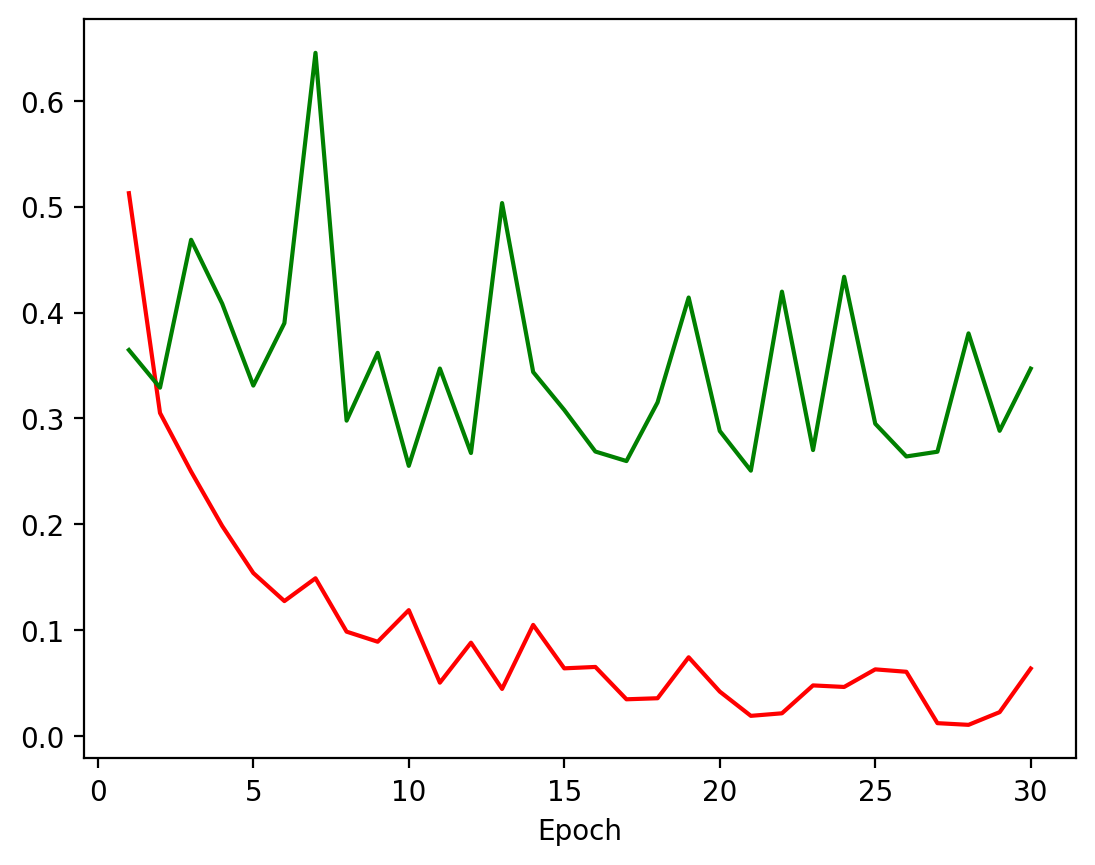

In [19]:
import matplotlib.pyplot as plot

plot.plot(dataframe.Epoch,dataframe.train_loss,'r',label="Training Loss")
plot.plot(dataframe.Epoch,dataframe.val_loss,'g',label="Validation Loss")
plot.xlabel("Epoch")
plot.show()

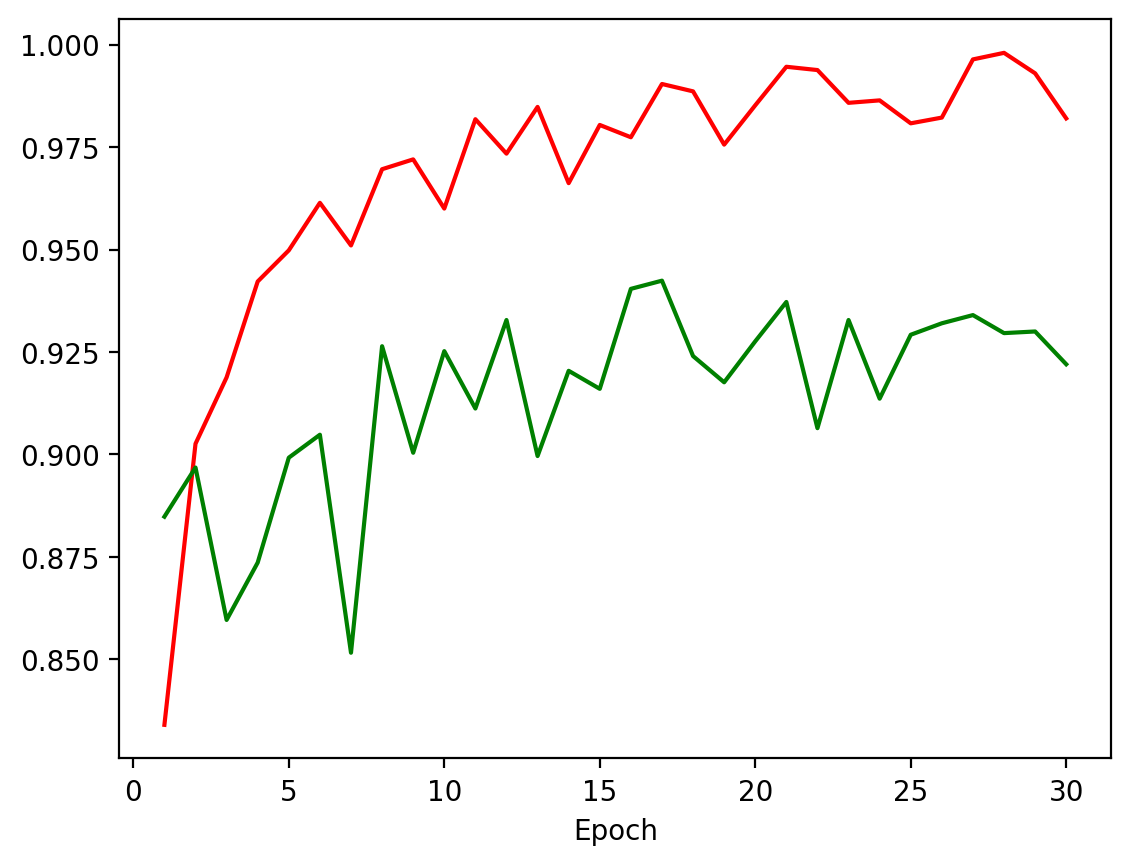

In [20]:
plot.plot(dataframe.Epoch,dataframe.train_accuracy,'r',label="Training Accuracy")
plot.plot(dataframe.Epoch,dataframe.val_accuracy,'g',label='Validation Accuracy')
plot.xlabel("Epoch")
plot.show()

In [21]:
model.eval()  # set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test accuracy: %d %%' % (100 * correct / total))

Test accuracy: 90 %


In [22]:
class_names = training_data.classes
class_names

['Daisy', 'Lavender', 'Lily', 'Rose', 'Sunflower']

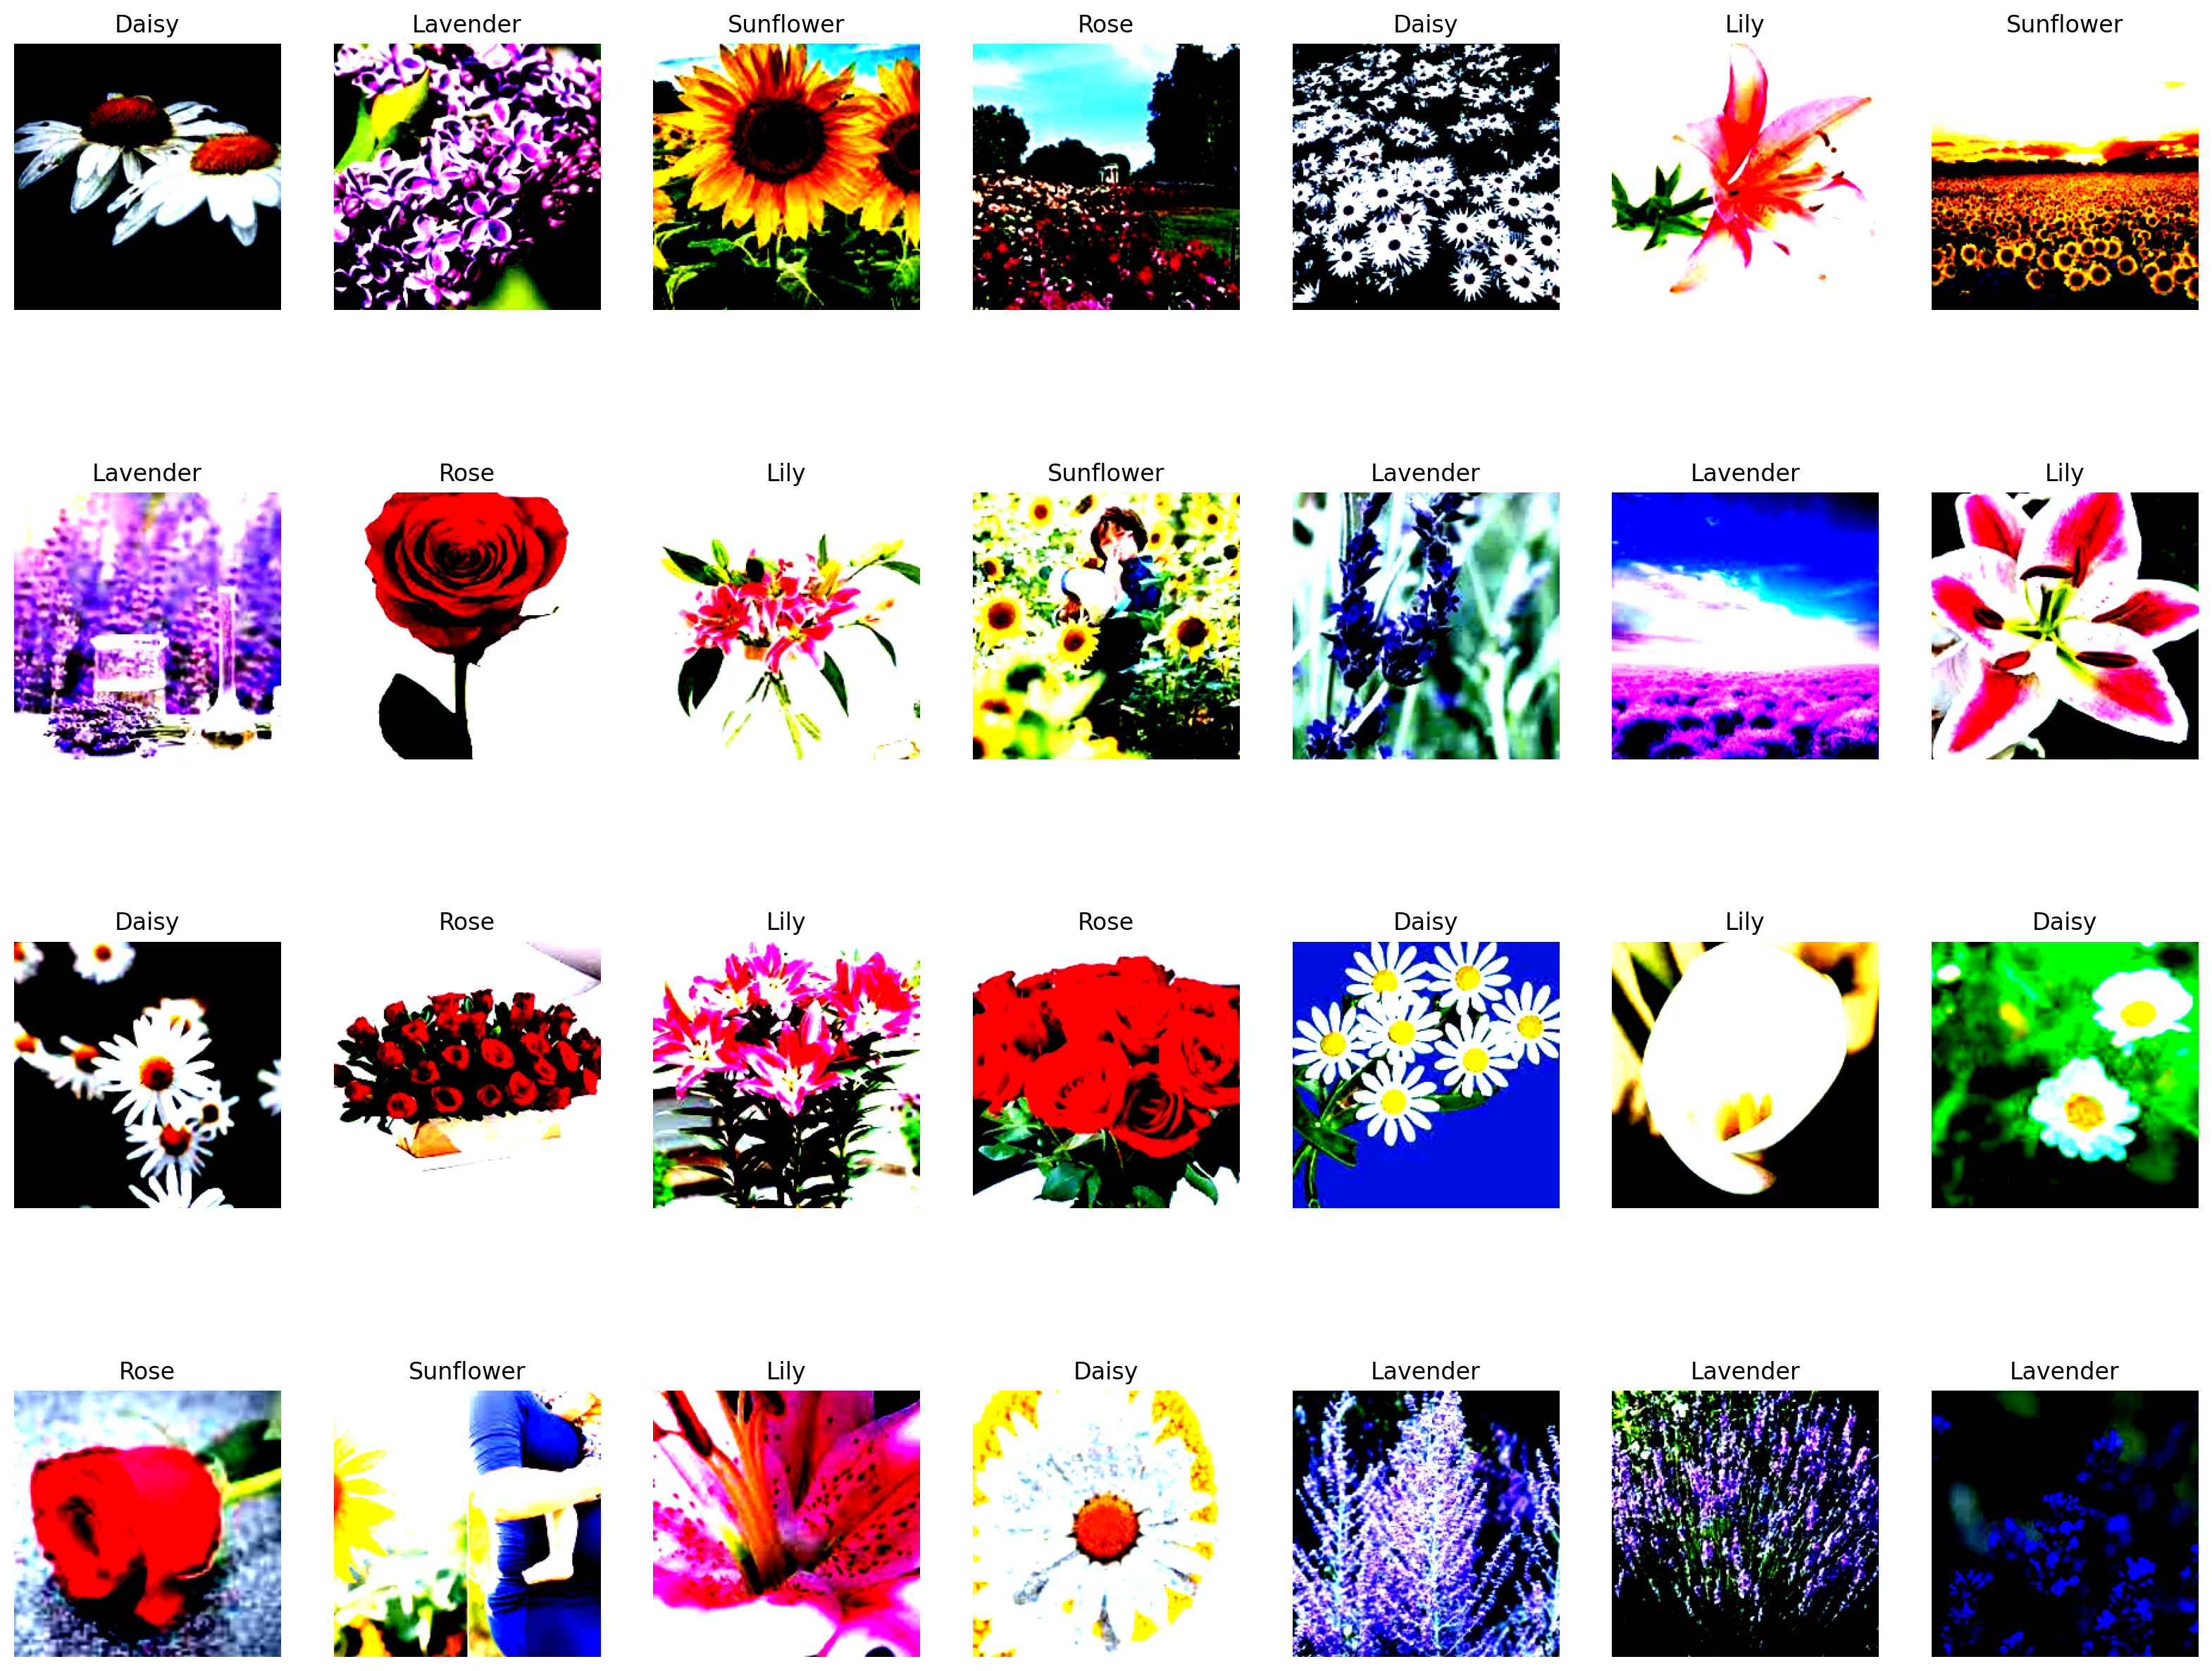

In [23]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
inputs = inputs.numpy()


# imshow()
fig = plt.figure(figsize=(20, 20))
for i in range(28):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(inputs[i].transpose((1, 2, 0)))  # Transpose to convert from (C, H, W) to (H, W, C)
    plt.title(f'{class_names[classes[i].item()]}')  # Use the dictionary to map class numbers to class names
    plt.axis('off')

# Show the plot

plt.show()
fig.savefig('r5_flower_images.png')

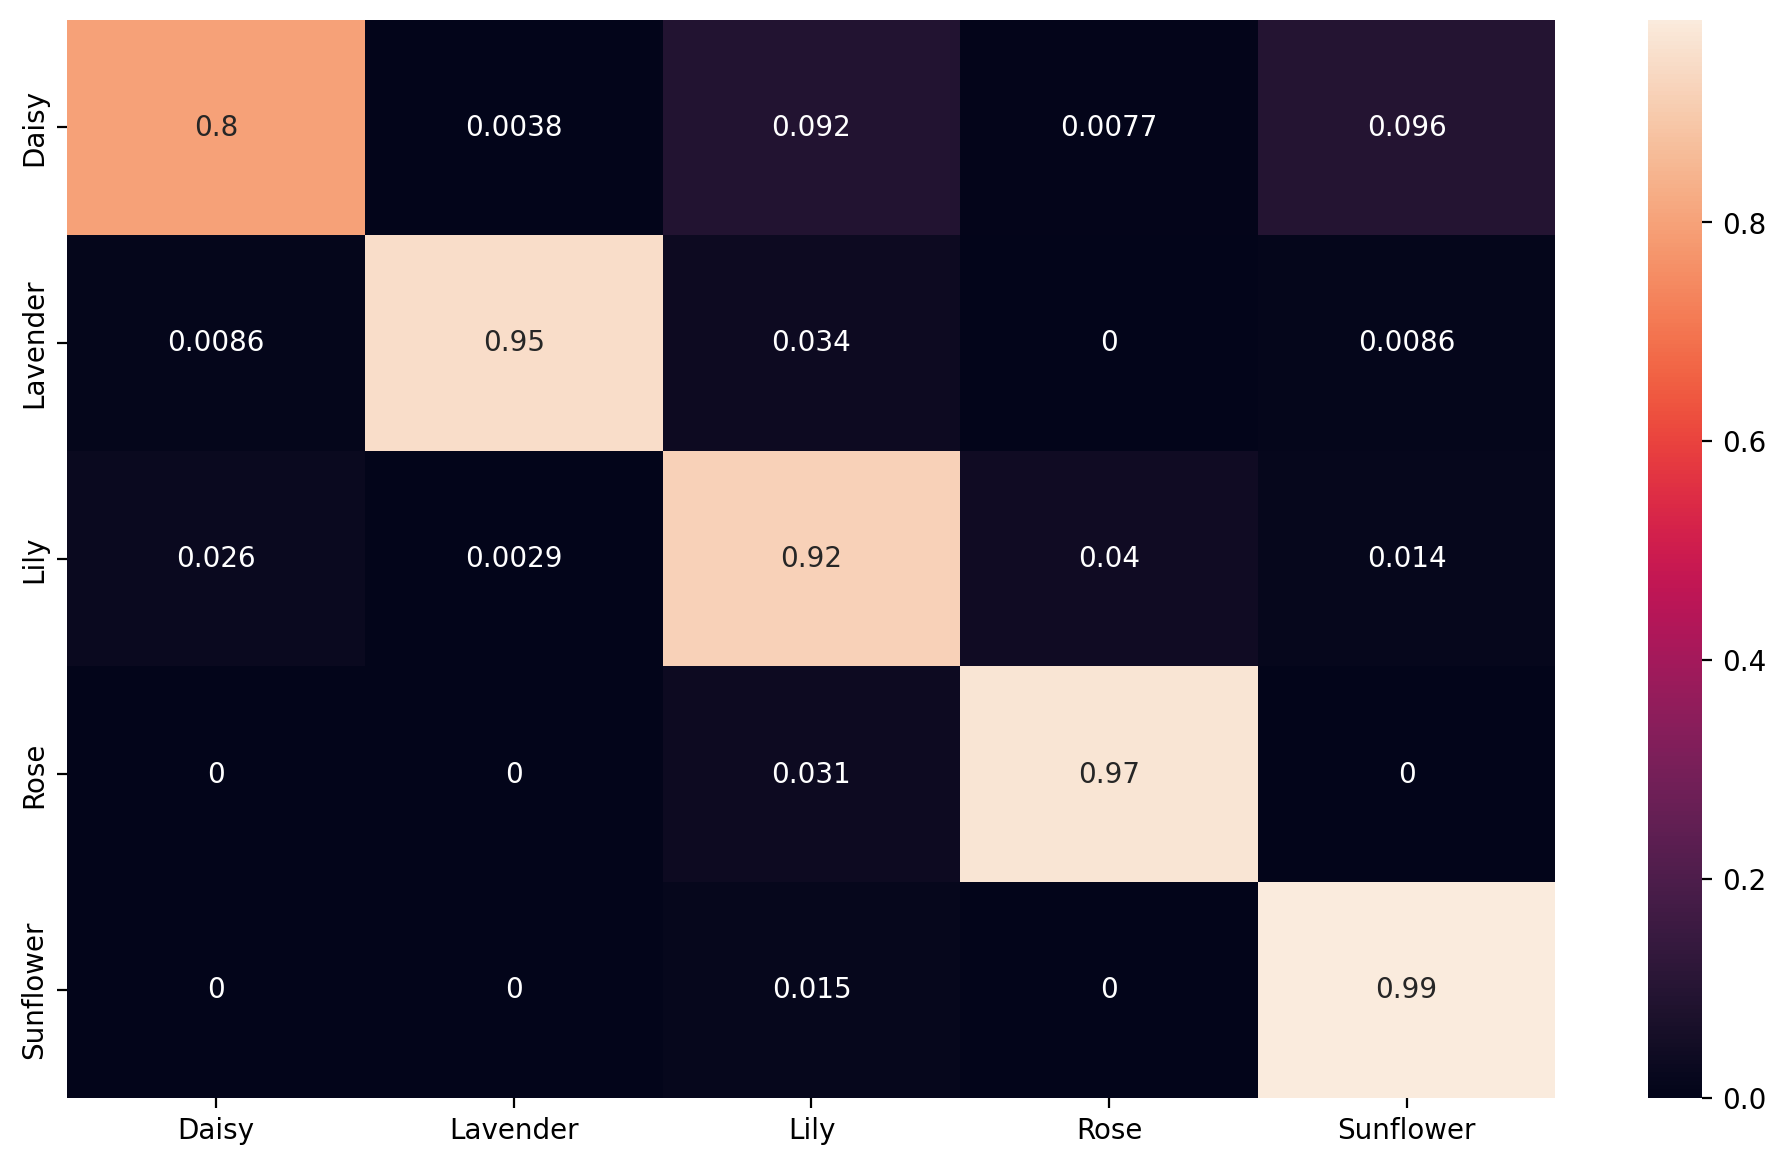

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
class_names = testing_data.classes


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('res_net_5_Classes_CM.png')

In [29]:
torch.save(model, f"resnet5.pth")
# pickle.dump(train_results, open(f"train_results.pkl", "wb"))

In [34]:
dataframe.to_csv("r_net_5_Classes.csv",index=False)

In [35]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, classification_report

print("Overall Accuracy: {:.4f}%".format(accuracy_score(y_true=y_true, y_pred=y_pred)))

print(classification_report(y_true, y_pred,target_names=testing_data.classes))

Overall Accuracy: 0.9040%
              precision    recall  f1-score   support

       Daisy       0.95      0.80      0.87       260
    Lavender       0.98      0.95      0.96       116
        Lily       0.91      0.92      0.91       350
        Rose       0.85      0.97      0.91        97
   Sunflower       0.81      0.99      0.89       135

    accuracy                           0.90       958
   macro avg       0.90      0.92      0.91       958
weighted avg       0.91      0.90      0.90       958



In [36]:
pip install ptflops

Note: you may need to restart the kernel to use updated packages.


In [37]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=False,
                                       print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity in FLOPs: ', macs*2))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity in FLOPs:   3649606666
Number of parameters:           11179077


In [38]:
#TSNE
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
targets_list = []
outputs_list = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_np = targets.data.cpu().numpy()

        outputs = model(inputs)
        outputs_np = outputs.data.cpu().numpy()

        targets_list.append(targets_np)
        outputs_list.append(outputs_np)

targets = np.concatenate(targets_list, axis=0)
outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

generating t-SNE plot...


/tmp/ipykernel_30/2811827539.py:15: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


TSNE Image is generated


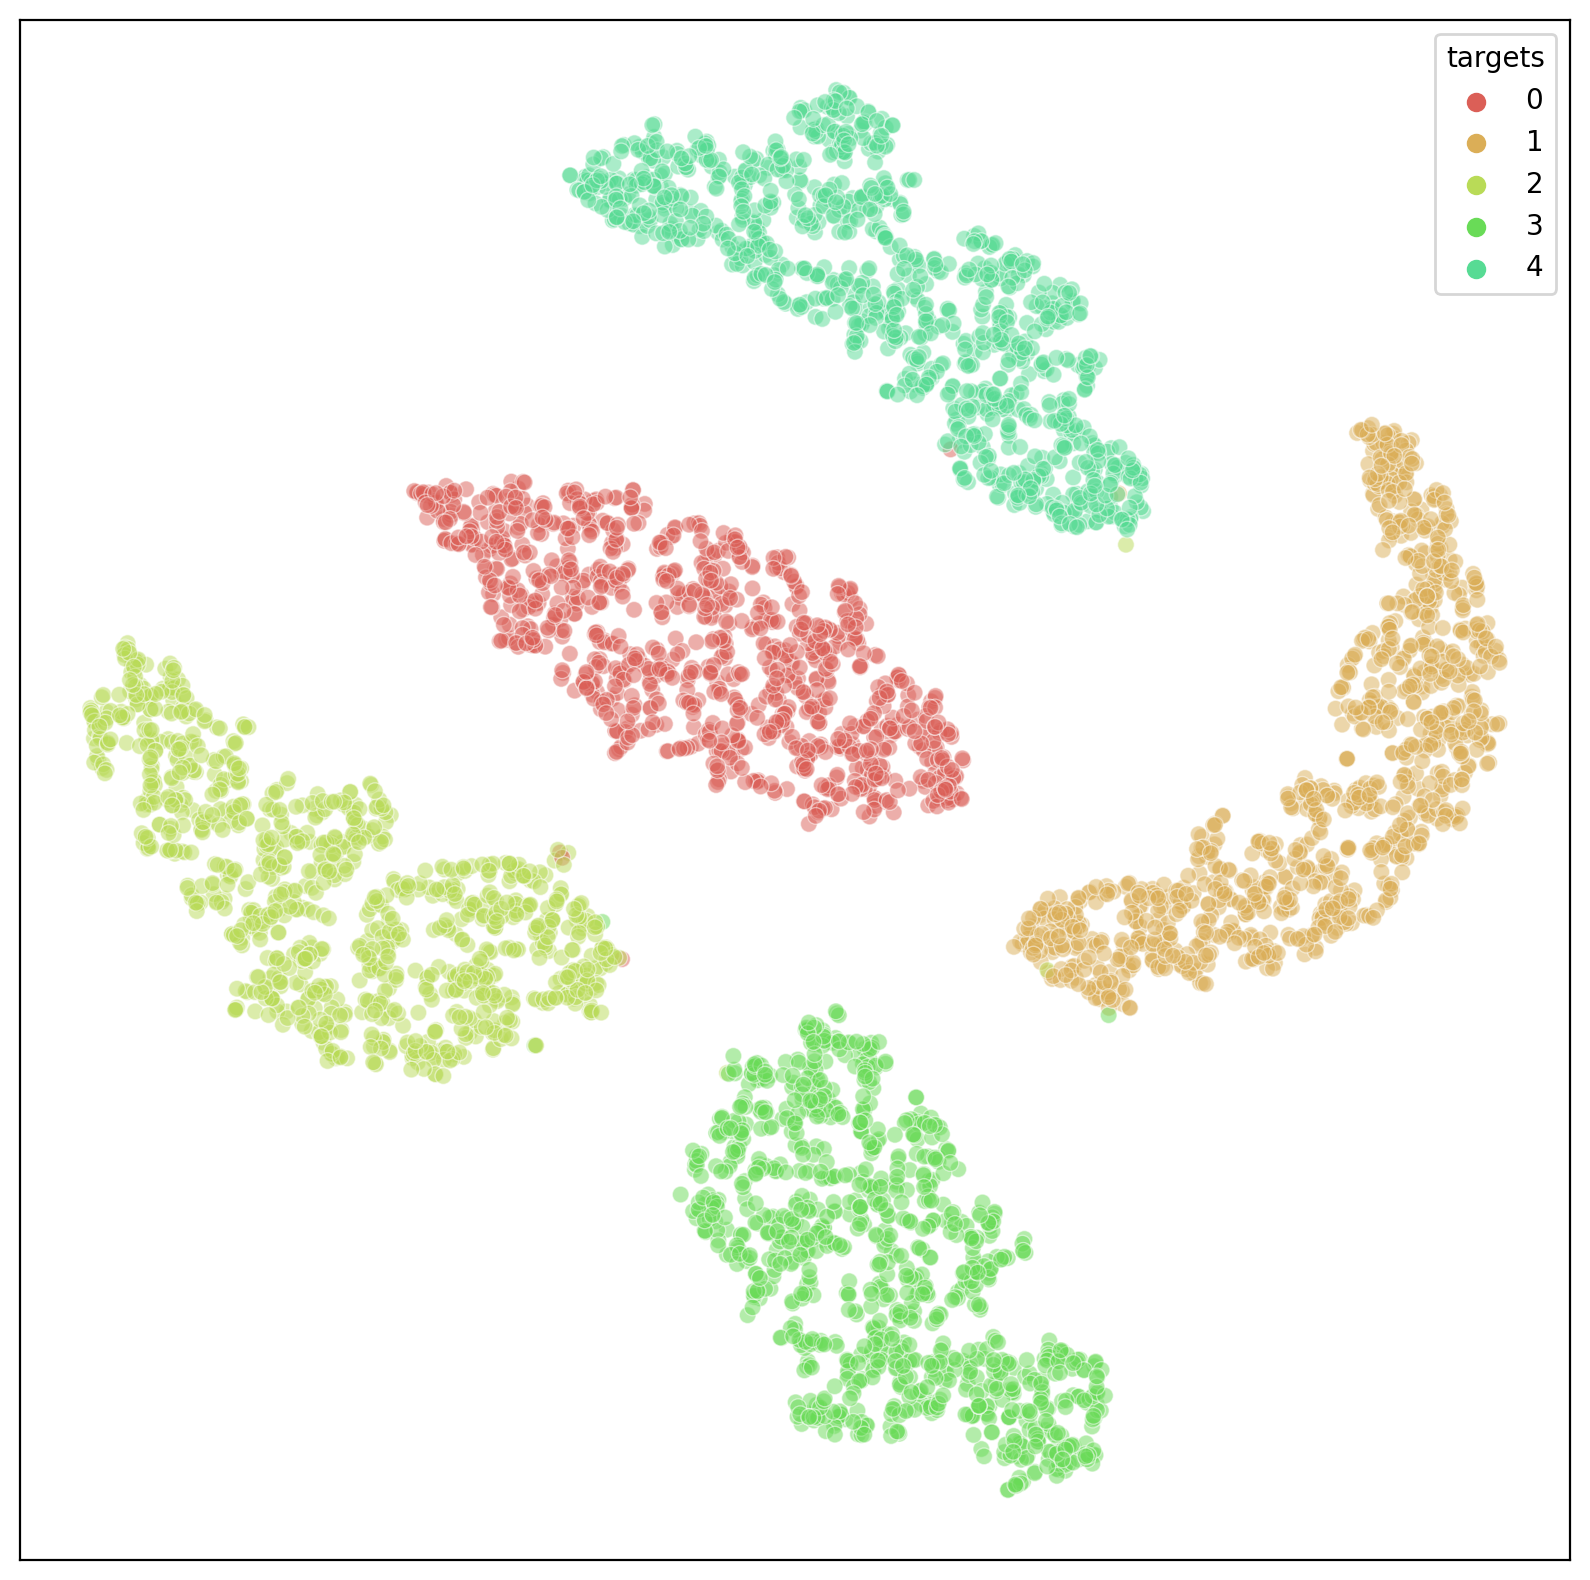

In [39]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
print('generating t-SNE plot...')
# tsne_output = bh_sne(outputs)
tsne = TSNE(random_state=0)
tsne_output = tsne.fit_transform(outputs)


df = pd.DataFrame(tsne_output, columns=['x', 'y'])
df['targets'] = targets

plt.rcParams['figure.figsize'] = 10, 10
sns.scatterplot(
    x='x', y='y',
    hue='targets',
    palette=sns.color_palette("hls", 10),
    data=df,
    marker='o',
    legend="full",
    alpha=0.5
)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

plt.savefig('tsne5_resnet.png', bbox_inches='tight')
print('TSNE Image is generated')